## Part 1 - Organize the Audio Data

In [1]:
import utils as u
import librosa
import soundfile as sf
import os
import numpy as np

In [2]:
# no need to convert again in the future, just use the files in wav_files folder directly
data_home = '/Volumes/T7/group5_DL4M/data/dev_set'
# u.convert_flac_to_wav_librosa(data_home)

In [3]:
wav_directory = '/Volumes/T7/group5_DL4M/dev_set/wav_files'
label_file = '/Users/mona/Documents/GitHub/group_5_DL4M1/data/dev.txt'

In [4]:
#is there a way to not having to load data and labels everytime?
audio_data, audio_labels = u.load_data(wav_directory, label_file)

In [5]:
# Example of using loaded data
print("Loaded", len(audio_data), "audio files.")
print("Sample labels:", audio_labels[:10]) # Print the first 10 labels

Loaded 41728 audio files.
Sample labels: ['bonafide', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'bonafide', 'deepfake', 'deepfake']


Look at one sample from the dataset

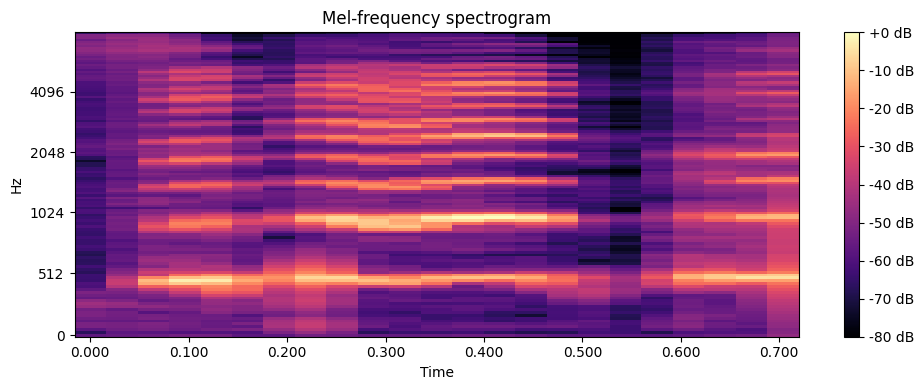

sr= 16000


In [6]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

# Load an audio file
file_path = '/Volumes/T7/group5_DL4M/dev_set/wav_files/CtrSVDD_0059_D_0000530.wav'
audio, sr = librosa.load(file_path, sr=None)  # Load with the original sample rate

# Play the audio
display(Audio(data=audio, rate=sr))

# Plot the spectrogram. refer: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=audio, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

print("sr=", sr)

Define Splite

In [7]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = u.split_data(
    audio_data, audio_labels, test_size=0.2, val_size=0.2)

print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Training data size: 25036
Validation data size: 8346
Test data size: 8346


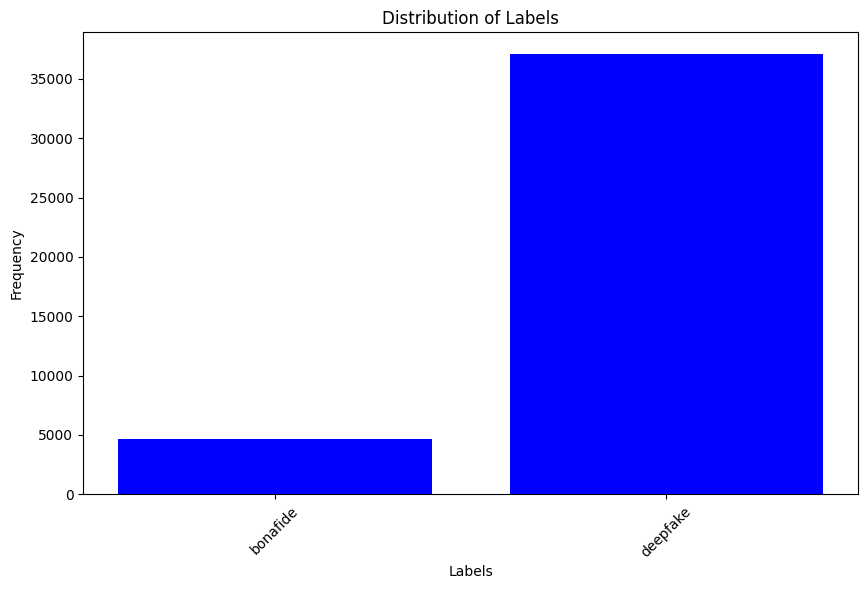

In [8]:
u.plot_label_distribution(audio_labels)

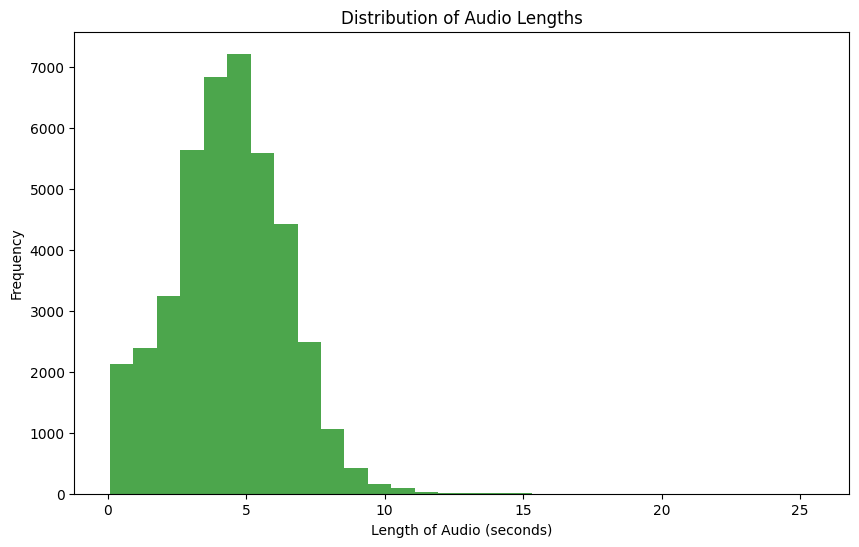

In [9]:
u.plot_audio_length_distribution(audio_data, sr)

### Data Preprocessing

MFCC & LFCC 

In [10]:
#look at the lfcc of one audio file
audio, sr = librosa.load('/Volumes/T7/group5_DL4M/dev_set/wav_files/CtrSVDD_0110_D_0012049.wav', sr=None)  # Load an audio file
mfccs = u.compute_mfcc(audio, sr)
print("MFCCs:", mfccs.shape)

MFCCs: (13, 126)


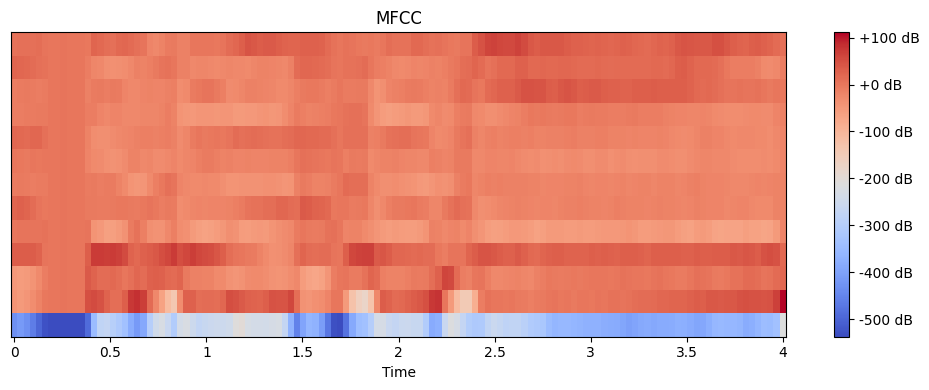

In [11]:
u.plot_mfcc(mfccs, sr)

In [12]:
lfccs = u.compute_lfcc(audio, sr)
print("LFCCs:", lfccs.shape)

LFCCs: (13, 126)


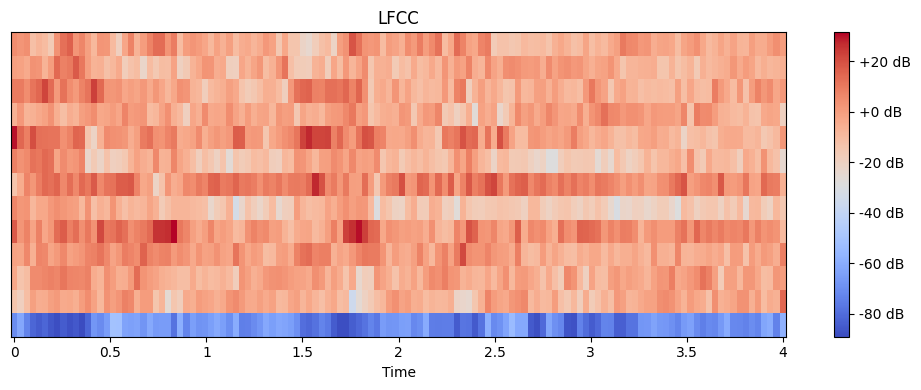

In [13]:
u.plot_lfcc(lfccs, sr)

Prepare Data for Modeling

In [14]:
# Batch Processing for Feature Extraction
# Test 
test_file_paths = ['/Volumes/T7/group5_DL4M/dev_set/wav_files/CtrSVDD_0059_D_0000525.wav',
                   '/Volumes/T7/group5_DL4M/dev_set/wav_files/CtrSVDD_0059_D_0000526.wav']  # Add your actual paths
test_features, test_sr = u.load_and_extract_features(test_file_paths, feature_type='lfcc')

print("Shape of extracted features:", test_features.shape)
print("Sample rate used:", test_sr)

Shape of extracted features: (26, 54)
Sample rate used: 16000


In [15]:
#test storing features in h5 file
import h5py

# Create an HDF5 file
with h5py.File('/Users/mona/Documents/GitHub/group_5_DL4M1/data/test_LFCC_features.h5', 'w') as h5f:
    # Create a dataset in the file
    h5f.create_dataset('LFCC_dataset_test', data=np.array(test_features))

In [16]:
test_features, test_sr = u.load_and_extract_features(test_file_paths, feature_type='mfcc')

print("Shape of extracted features:", test_features.shape)
print("Sample rate used:", test_sr)

Shape of extracted features: (26, 54)
Sample rate used: 16000


In [17]:
# Parallel processing from ChatGPT
# from concurrent.futures import ProcessPoolExecutor

def process_file(file_path):
    features, _ = u.load_and_extract_features([file_path], feature_type='lfcc')
    return features

In [18]:
dataset_directory = '/Volumes/T7/group5_DL4M/dev_set/wav_files'

#refer to ChatGPT
audio_files = [os.path.join(dataset_directory, f) for f in os.listdir(dataset_directory) if f.endswith('.wav') and os.path.isfile(os.path.join(dataset_directory, f))]

# with ProcessPoolExecutor() as executor:
#     all_features = list(executor.map(process_file, audio_files))

# alternative if not using parallel processing

all_features = []
for file_path in audio_files:
    feature = process_file(file_path)
    if feature is not None:
        all_features.append(feature)

# print("Features extracted. Number of files processed:", len(all_features))

# Optionally filter out None values and check shapes
valid_features = []
shapes = set()
for feature in all_features:
    valid_features.append(feature)
    shapes.add(feature.shape)

print("Unique feature shapes:", shapes)

Unique feature shapes: {(13, 88), (13, 97), (13, 335), (13, 106), (13, 362), (13, 200), (13, 209), (13, 218), (13, 227), (13, 236), (13, 474), (13, 65), (13, 74), (13, 83), (13, 321), (13, 92), (13, 330), (13, 101), (13, 339), (13, 348), (13, 186), (13, 195), (13, 204), (13, 213), (13, 222), (13, 51), (13, 60), (13, 69), (13, 78), (13, 316), (13, 87), (13, 325), (13, 334), (13, 352), (13, 590), (13, 181), (13, 190), (13, 199), (13, 208), (13, 446), (13, 217), (13, 46), (13, 55), (13, 64), (13, 302), (13, 73), (13, 311), (13, 82), (13, 320), (13, 329), (13, 338), (13, 167), (13, 176), (13, 185), (13, 194), (13, 432), (13, 203), (13, 32), (13, 41), (13, 50), (13, 59), (13, 297), (13, 68), (13, 306), (13, 315), (13, 324), (13, 333), (13, 162), (13, 171), (13, 180), (13, 189), (13, 198), (13, 27), (13, 454), (13, 36), (13, 45), (13, 283), (13, 54), (13, 292), (13, 63), (13, 301), (13, 310), (13, 319), (13, 148), (13, 157), (13, 166), (13, 175), (13, 184), (13, 13), (13, 22), (13, 449), (13

In [19]:
#where kernel often crashes
# Determine the maximum length from the shapes printed
max_length = 0
for shape in shapes:
    length = shape[1]
    if length > max_length:

        max_length = length

# Pad all features to the maximum length
uniform_features = u.pad_features(all_features, max_length)

# Convert list of arrays into a single numpy array for storage
uniform_features_array = np.array(uniform_features)

In [20]:
# Create an HDF5 file
with h5py.File('/Users/mona/Documents/GitHub/group_5_DL4M1/data/LFCC_features.h5', 'w') as h5f:
    # Create a dataset in the file
    h5f.create_dataset('LFCC_dataset_1', data=np.array(uniform_features_array))


In [21]:
print("Shape of the dataset:", uniform_features_array.shape)

Shape of the dataset: (41728, 13, 798)


In [22]:
train_data_feature, val_data_feature, test_data_feature, train_labels, val_labels, test_labels = u.split_data(
    uniform_features_array, audio_labels, test_size=0.2, val_size=0.2)

print("Training data size:", len(train_data_feature))
print("Validation data size:", len(val_data_feature))
print("Test data size:", len(test_data_feature))

Training data size: 25036
Validation data size: 8346
Test data size: 8346


### Model Training

In [23]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [24]:
import tensorflow as tf
train_labels_reshaped = tf.reshape(train_labels, [train_labels.shape[0], 1, 1])
val_labels_reshaped = tf.reshape(val_labels, [val_labels.shape[0], 1, 1])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-04-30 13:50:48.523437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 13:50:48.526326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
train_data_feature = train_data_feature[..., np.newaxis]
val_data_feature = val_data_feature[..., np.newaxis]
test_data_feature = test_data_feature[..., np.newaxis]

In [26]:
train_data_feature_1 = np.array(train_data_feature, dtype=float)
val_data_feature_1 = np.array(val_data_feature, dtype=float)
test_data_feautre_1 = np.array(test_data_feature, dtype=float)

In [27]:
train_labels = np.where(train_labels == 'deepfake', 1, 0)
val_labels = np.where(val_labels == 'deepfake', 1, 0)
test_labels = np.where(test_labels == 'deepfake', 1, 0)

In [28]:
print("Train data shape:", train_data_feature_1.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data_feature_1.shape)
print("Validation labels shape:", val_labels.shape)

Train data shape: (25036, 13, 798, 1)
Train labels shape: (25036,)
Validation data shape: (8346, 13, 798, 1)
Validation labels shape: (8346,)


In [29]:
print("Feature array shape:", uniform_features_array.shape)

input_shape = uniform_features_array.shape  
print("Input shape for model:", input_shape)

Feature array shape: (41728, 13, 798)
Input shape for model: (41728, 13, 798)


In [30]:
input_shape = uniform_features_array.shape 
from models import build_model
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 798, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 798, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 798, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 798, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 798, 64)        16448     
                                                                 
 flatten (Flatten)           (None, 153216)            0

In [31]:
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"checkpoints/audio_convnet.keras",
        save_best_only=True,
        monitor="val_loss")
]

batch_size = 32
history = model.fit(
        x=train_data_feature_1,
        y=train_labels, 
        validation_data=(val_data_feature_1, val_labels),
        epochs=10,
        batch_size=batch_size,
        callbacks=callbacks
    )

2024-04-30 13:51:01.585559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-30 13:51:05.555860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


783/783 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8865WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x5bf29eb80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-30 13:52:31.207086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


783/783 [==============================] - 105s 129ms/step - loss: 0.4003 - accuracy: 0.8865 - val_loss: 0.3227 - val_accuracy: 0.8886
Epoch 2/10
783/783 [==============================] - 99s 126ms/step - loss: 0.3090 - accuracy: 0.8886 - val_loss: 0.3060 - val_accuracy: 0.8916
Epoch 3/10
783/783 [==============================] - 96s 123ms/step - loss: 0.2670 - accuracy: 0.8933 - val_loss: 0.2564 - val_accuracy: 0.8952
Epoch 4/10
783/783 [==============================] - 96s 122ms/step - loss: 0.2127 - accuracy: 0.9133 - val_loss: 0.2349 - val_accuracy: 0.9065
Epoch 5/10
783/783 [==============================] - 96s 122ms/step - loss: 0.1698 - accuracy: 0.9312 - val_loss: 0.2716 - val_accuracy: 0.8838
Epoch 6/10
783/783 [==============================] - 95s 122ms/step - loss: 0.1320 - accuracy: 0.9456 - val_loss: 0.2964 - val_accuracy: 0.9037
Epoch 7/10
783/783 [==============================] - 95s 122ms/step - loss: 0.0906 - accuracy: 0.9643 - val_loss: 0.3902 - val_accuracy: 0.

#### Check loss and accuracy

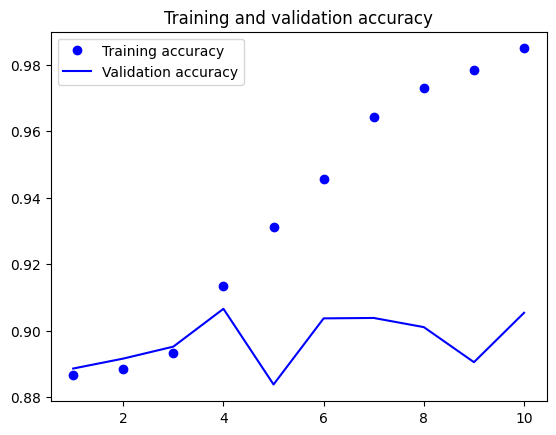

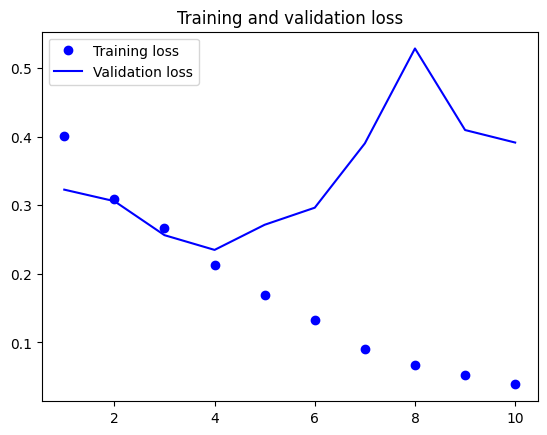

In [32]:
u.plot_loss(history)

In [33]:
# Load the best checkpoint of the model
model_reloaded = keras.models.load_model("checkpoints/audio_convnet.keras")



In [34]:
print(test_data_feature)

[[[[-8.91301114e+01]
   [-9.45278847e+01]
   [-8.41057424e+01]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 3.53830954e+00]
   [ 8.64724986e-01]
   [-7.85315240e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-1.80821882e-02]
   [ 8.67872509e+00]
   [-1.81077556e-01]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  ...

  [[ 8.88794485e+00]
   [ 1.56976555e+01]
   [ 1.28400846e+01]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-8.12385839e+00]
   [-7.12683980e-02]
   [-7.56082902e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-1.32686683e+01]
   [-1.60563977e-01]
   [ 3.02079691e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]]


 [[[-7.15102172e+01]
   [-7.82640488e+01]
   [-7.64757967e+01]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 1.74884551e+01]
   [ 9.47482033e+00]
   [

In [35]:
sample_test = test_data_feature[0:1]  # Get a single batch item
try:
    result = model_reloaded.predict(sample_test)
    print("Single sample prediction:", result)
except Exception as e:
    print("Error during single sample prediction:", e)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step
Single sample prediction: [[0.77945375]]


2024-04-30 14:07:10.970879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [36]:
model_reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 798, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 798, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 798, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 798, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 798, 64)        16448     
                                                                 
 flatten (Flatten)           (None, 153216)            0

### Transfer Learning

#### YAMNet

In [37]:
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [38]:
from models import tcn_model

input_shape =  uniform_features_array.shape
# Create a tcn model that processes the embeddings
tcn_yamnet = tcn_model(input_shape)

# Print model summary
tcn_yamnet.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Exception encountered when calling layer "residual_block_0" "                 f"(type ResidualBlock).

Input 0 of layer "spatial_dropout1d" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 13, 798, 64)

Call arguments received by layer "residual_block_0" "                 f"(type ResidualBlock):
  • inputs=tf.Tensor(shape=(None, 13, 798, 1), dtype=float32)
  • training=None

In [ ]:
# Define a mapping function to extract embeddings
def map_function(audio, label):
   return u.extract_yamnet_embedding(audio, yamnet), label

# Check input shape from example in the data
for e, l in train_data_feature.map(map_function).take(1):
    print(e.shape)

In [ ]:
batch_size = 32
model_path = "checkpoints/yamnet_model.json"
model_weights = "checkpoints/yamnet_weights.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=model_weights,
      save_best_only=True,
      save_weights_only=True,
      monitor="val_loss")
]

history = tcn_yamnet.fit(train_data_feature_1.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    validation_data=val_data_feature_1.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    epochs=10,
    callbacks=callbacks)

model_as_json = tcn_yamnet.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_as_json)

In [ ]:
u.plot_loss(history)

In [ ]:
# Load the best checkpoint of the model 
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
metrics = ["accuracy"]
tcn_yamnet_reloaded = u.reload_tcn(model_path, model_weights, optimizer, loss, metrics)

# Evaluate the model on the test set
test_loss_yamnet, test_acc_yamnet = tcn_yamnet_reloaded.evaluate(test_data_feature.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size))
print(f"Test Loss: {test_loss_yamnet:.4f}, Test Accuracy: {test_acc_yamnet:.4f}")